# Is the snow bias over Himalaya present in all experiments: historical, AMIP and land-hist?
- historical: all coupled
- AMIP: LMDZ/Orchidée with prescribed SST
- land-hist: Orchidée with prescribed atmosphere and SST

-> climatology on the reference period 1981-2014 (SnowCMIP6 paper) compared to the Rutger University data set: Weekly Snow Cover Extent Dataset Access (https://climate.rutgers.edu/snowcover/docs.php?target=datareq)

## Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../') # to include my util file in previous directory
import utils as u # my personnal functions
u.check_python_version()
u.check_virtual_memory()

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 110 GB / percent used: 12.0 %


## Load model data

In [2]:
# Define period
period = slice('1981','2014')

In the next cells the `chunks={'time': 120}` allows not to load full data set but take it by chunks of 10 years. This allows to parallelize the computation and/or make fit into the memory (see **xarray/dask**: http://xarray.pydata.org/en/stable/dask.html)

In [3]:
# Get historical snc
snc_historical = u.get_data_IPSL_CM6A_LR('snc', experiment='historical', time=period, chunks={'time': 120})
snc_historical

<xarray.DataArray 'snc' (realization: 32, time: 408, lat: 143, lon: 144)>
dask.array<concatenate, shape=(32, 408, 143, 144), dtype=float32, chunksize=(1, 120, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' ... 'r32i1p1f1'
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [4]:
# Get AMIP snc
snc_amip = u.get_data_IPSL_CM6A_LR('snc', experiment='amip', time=period, chunks={'time': 120})
snc_amip

<xarray.DataArray 'snc' (realization: 21, time: 408, lat: 143, lon: 144)>
dask.array<concatenate, shape=(21, 408, 143, 144), dtype=float32, chunksize=(1, 108, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' ... 'r21i1p1f1'
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [5]:
# Get land-hist snc
snc_land_hist = u.get_data_IPSL_CM6A_LR('snc', experiment='land-hist', time=period, chunks={'time': 120})
snc_land_hist

<xarray.DataArray 'snc' (realization: 1, time: 408, lat: 143, lon: 144)>
dask.array<broadcast_to, shape=(1, 408, 143, 144), dtype=float32, chunksize=(1, 120, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * realization  (realization) object 'r1i1p1f1'
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

## Load Rutger University data set

In [40]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
ds_rutger

<xarray.Dataset>
Dimensions:               (cols: 88, rows: 88, time: 1774)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-05 ... 2014-12-29
    snow_cover_threshold  float32 ...
    latitude              (rows, cols) float64 ...
    longitude             (rows, cols) float64 ...
Dimensions without coordinates: cols, rows
Data variables:
    coord_system          |S1 ...
    land                  (rows, cols) float32 ...
    area                  (rows, cols) float32 ...
    snow_cover_extent     (time, rows, cols) float32 ...
Attributes:
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        nhsce_v01r01_19661004_20191202.nc
    naming_authority:          gov.noaa.ncdc
    metadata_link:             https://doi.org/10.7289/V5N014G9
    title:                     Climate Data Record (CDR) of No

In [47]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    snc_rutger = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
snc_rutger.attrs['units'] = '%'

# Resamble data per month (from per week) 
snc_rutger = snc_rutger.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)

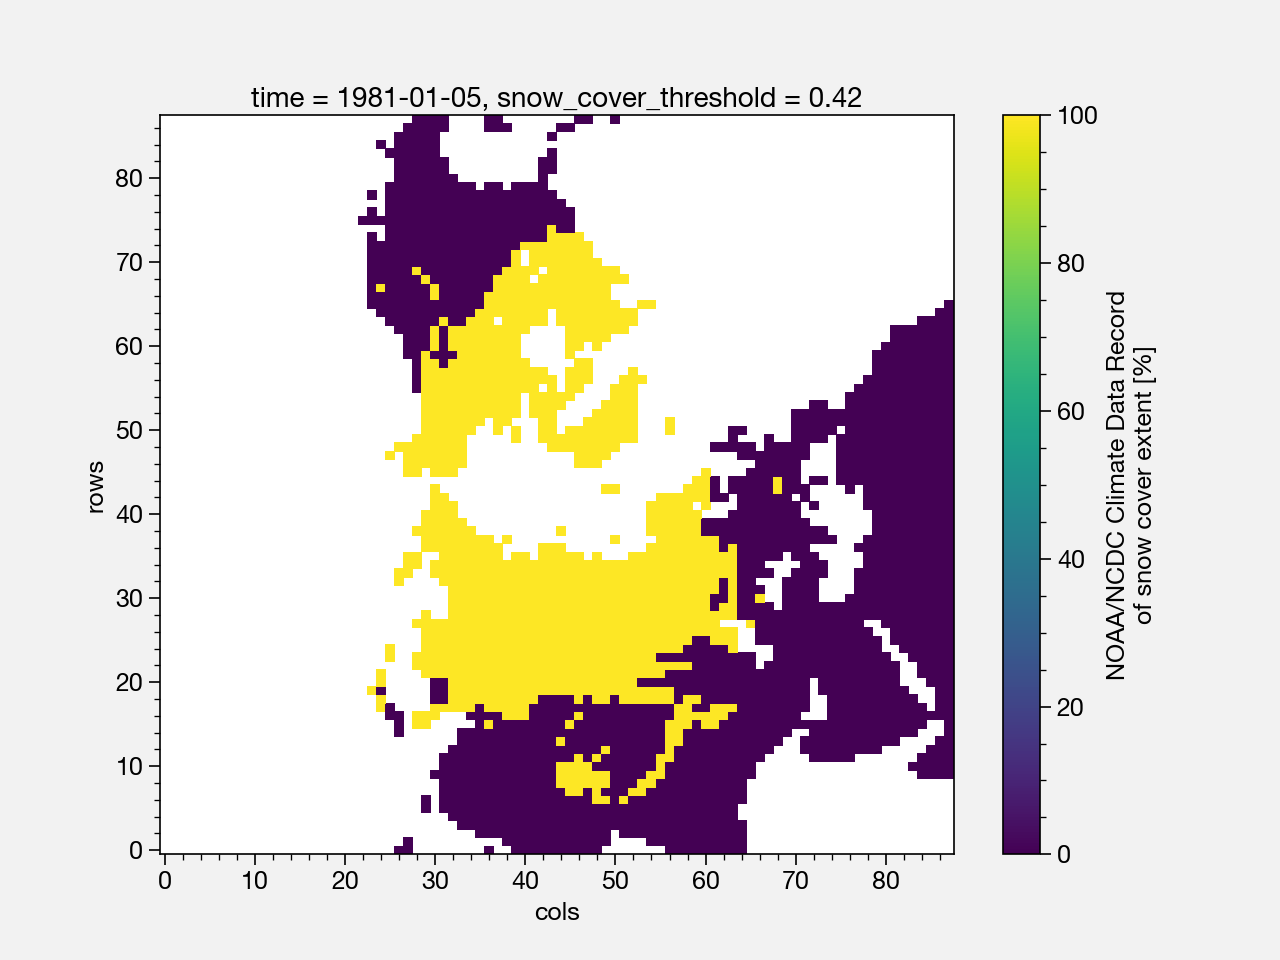

In [48]:
snc_rutger[0].plot()

In [ ]:
# Convert to %
with xr.set_options(keep_attrs=True):
    snc_rutger = ds.snow_cover_extent.where(ds.land == 1)*100
    
nhsce.attrs['units'] = '%'
nhsce

## Fisrt guess plot 
Time: January 1981 / Realization: r1i1p1

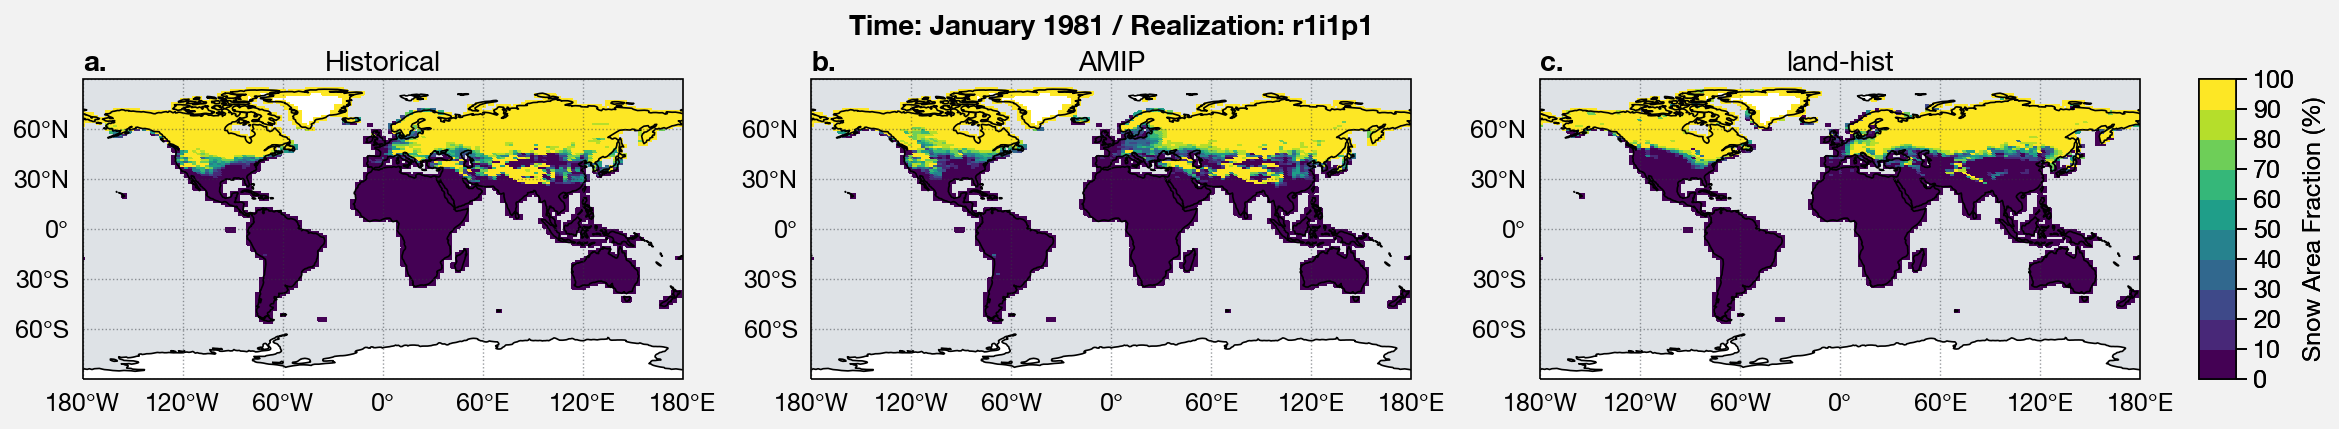

In [35]:
# First guess plot comparison
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, share=3, axwidth=3)

cmap='viridis'
levels=plot.arange(0,100,10)

axs[0].pcolormesh(snc_historical[0,0], cmap=cmap, levels=levels)
axs[0].format(title='Historical')
axs[1].pcolormesh(snc_amip[0,0], cmap=cmap, levels=levels)
axs[1].format(title='AMIP')
m = axs[2].pcolormesh(snc_land_hist[0,0], cmap=cmap, levels=levels)
axs[2].format(title='land-hist')

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3',
    suptitle="Time: January 1981 / Realization: r1i1p1",
    lonlines=60, latlines=30, abc=True, abcstyle='a.'
)

land-hist seems to less overestimate the snow cover over the Himalya and Rocky Mountains

In [ ]:
/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/amip/r1i1p1f1/LImon/snc/gr/latest/snc_LImon_IPSL-CM6A-LR_amip_r1i1p1f1_gr_185001-201412.nc
/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/amip/r10i1p1f1/LImon/snc/gr/latest/snc_LImon_IPSL-CM6A-LR_amip_r10i1p1f1_gr_195801-201412.nc

In [4]:
# Get historical snc
snc_historical = u.get_data_IPSL_CM6A_LR('snc', experiment='historical', time=period, chunks={'time': 120})
snc_historical

<xarray.DataArray 'snc' (realization: 32, time: 408, lat: 143, lon: 144)>
dask.array<concatenate, shape=(32, 408, 143, 144), dtype=float32, chunksize=(1, 120, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' ... 'r32i1p1f1'
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

## Compute the ensemble mean

In [11]:
snc_ens_avg = snc.mean('realization', skipna=True, keep_attrs=True)
snc_ens_avg

<xarray.DataArray 'snc' (time: 1980, lat: 143, lon: 144)>
dask.array<mean_agg-aggregate, shape=(1980, 143, 144), dtype=float32, chunksize=(120, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [14]:
data_path = '/data/mlalande/IPSL_CM6A_LR_historical'
snc_ens_avg.to_netcdf(data_path+'/snc_ens_avg.nc')

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Load the ensemble mean

In [29]:
data_path = '/data/mlalande/IPSL_CM6A_LR_historical'
snc_ens_avg = xr.open_dataarray(data_path+'/snc_ens_avg.nc')
snc_ens_avg

<xarray.DataArray 'snc' (time: 1980, lat: 143, lon: 144)>
[40772160 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

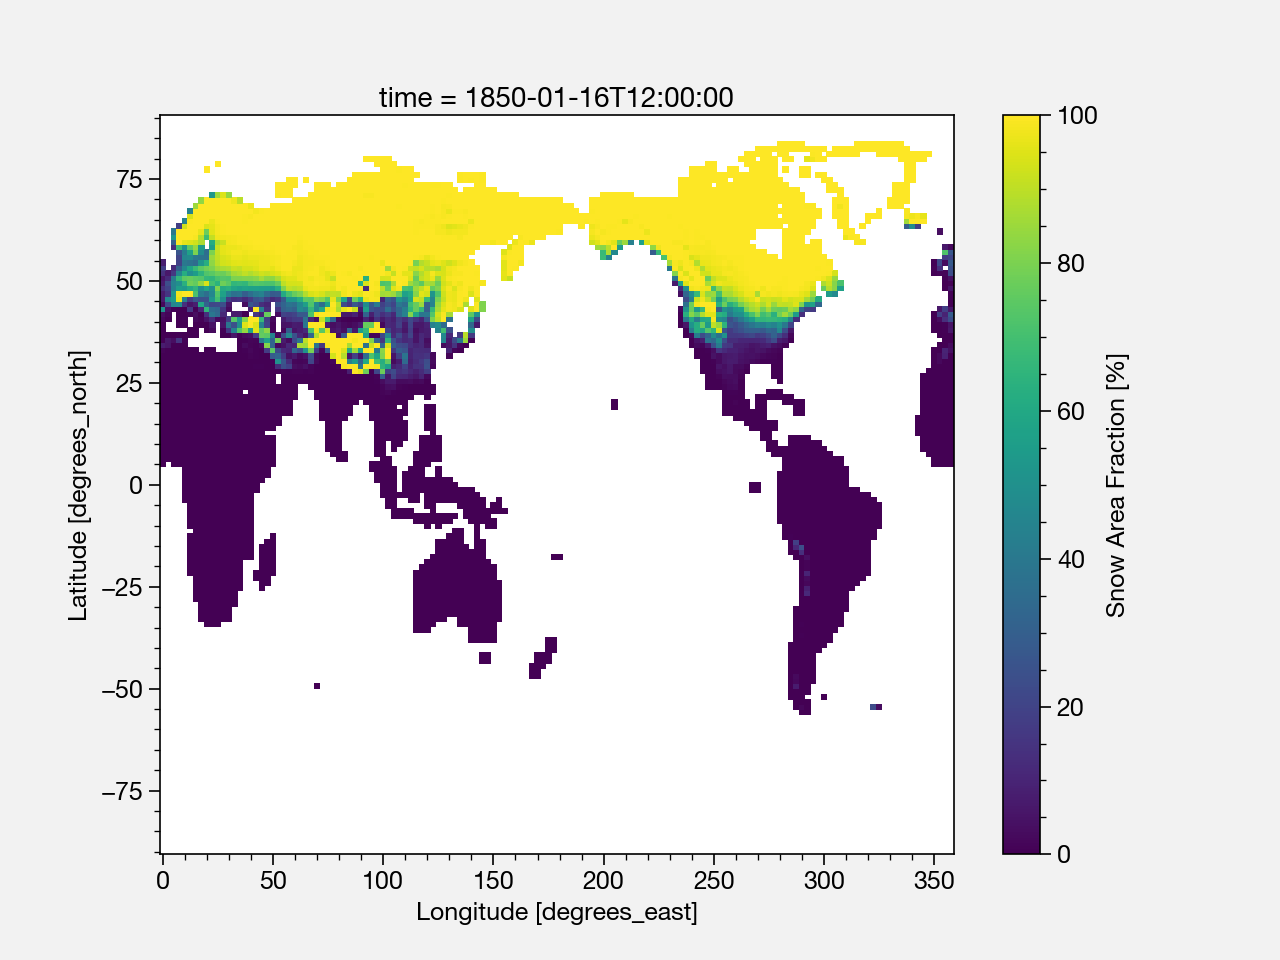

In [30]:
snc_ens_avg[0].plot()

In [31]:
# Get the calendar
calendar = snc_ens_avg.time.encoding['calendar']
calendar

'gregorian'

In [32]:
# Compute the yearly mean
snc_year_mean = u.year_mean(snc_ens_avg, calendar=calendar)
snc_year_mean

<xarray.DataArray (year: 165, lat: 143, lon: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, na

In [33]:
# Compute the spatial average
snc_year_mean_spatial_avg = u.spatial_average(snc_year_mean)
snc_year_mean_spatial_avg

<xarray.DataArray (year: 165)>
array([16.61043726, 16.53923748, 16.57428629, 16.57882033, 16.47735636,
       16.56049757, 16.64183945, 16.43492389, 16.56553333, 16.59174409,
       16.65594314, 16.54662606, 16.64182673, 16.57632752, 16.7207685 ,
       16.5332188 , 16.57714178, 16.53025843, 16.65724891, 16.61558337,
       16.58767111, 16.56227691, 16.65205921, 16.64484477, 16.59091222,
       16.53397885, 16.60175027, 16.57598036, 16.40763349, 16.50444124,
       16.55186841, 16.60374414, 16.48899752, 16.40450891, 16.90349944,
       16.88551098, 16.70927608, 16.67665797, 16.68393266, 16.61377833,
       16.7334039 , 16.80447611, 16.81135311, 16.55554656, 16.61466469,
       16.59141396, 16.60269266, 16.51356796, 16.47272675, 16.44873792,
       16.52132802, 16.58217992, 16.53120299, 16.91936176, 16.89325146,
       16.78174344, 16.58357938, 16.70951205, 16.6968653 , 16.59296666,
       16.53963015, 16.57702128, 16.98535383, 16.99055523, 16.80685802,
       16.64432258, 16.73046646, 

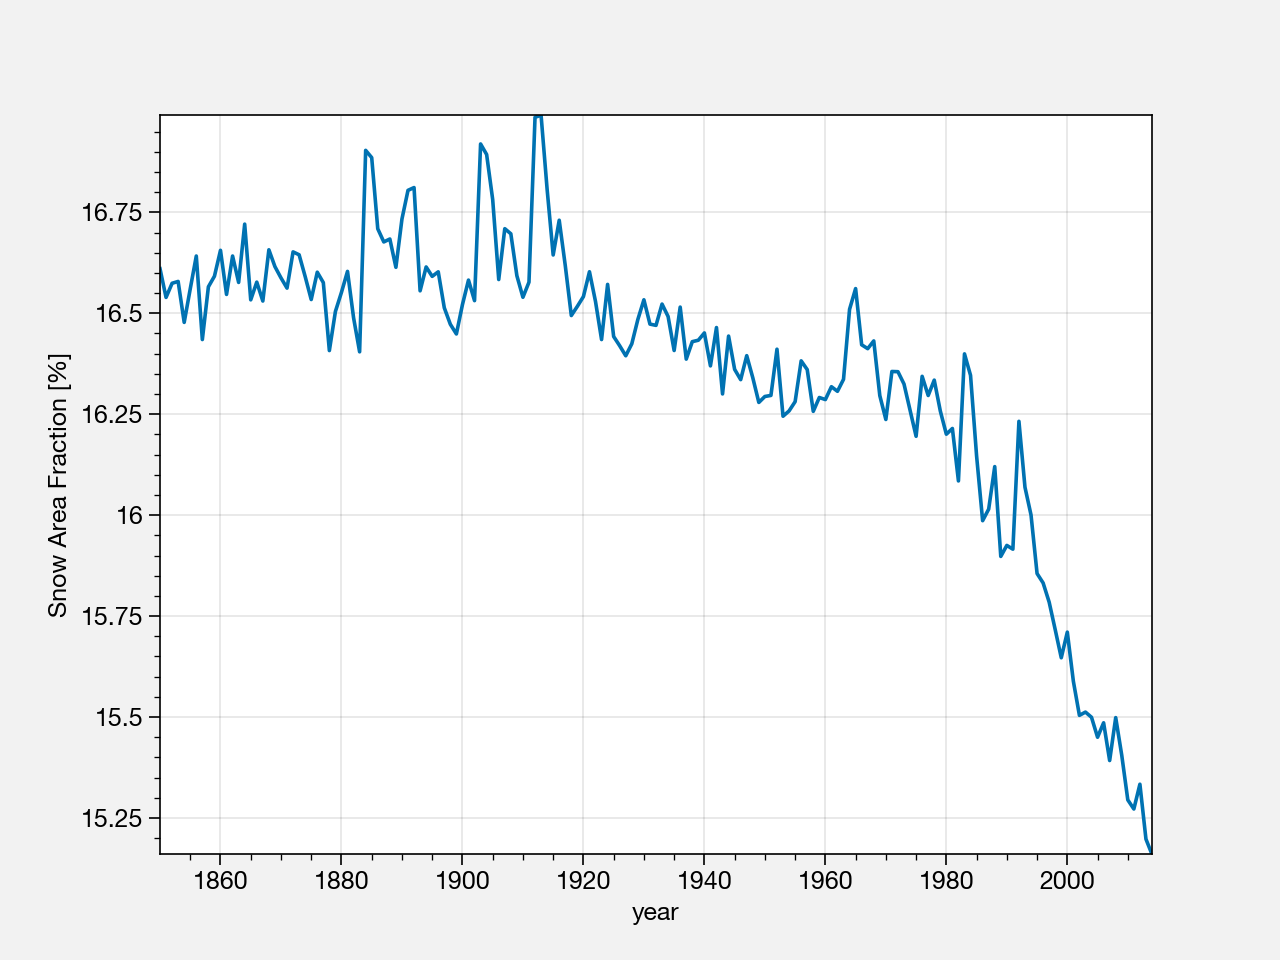

In [34]:
# Plot snow area fraction of lands! (we do not take into account the ocean and ice-sheets)
snc_year_mean_spatial_avg.plot()

# Load reanalysis

In [35]:
snowc_mon_noaaV2c = xr.open_dataset('/home/msantola/TP_CLiMAF/ReferenceSNOW/SNC/SNCRefData/snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc').snowc
snowc_mon_noaaV2c

<xarray.DataArray 'snowc' (time: 1968, lat: 94, lon: 192)>
[35518464 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Gri

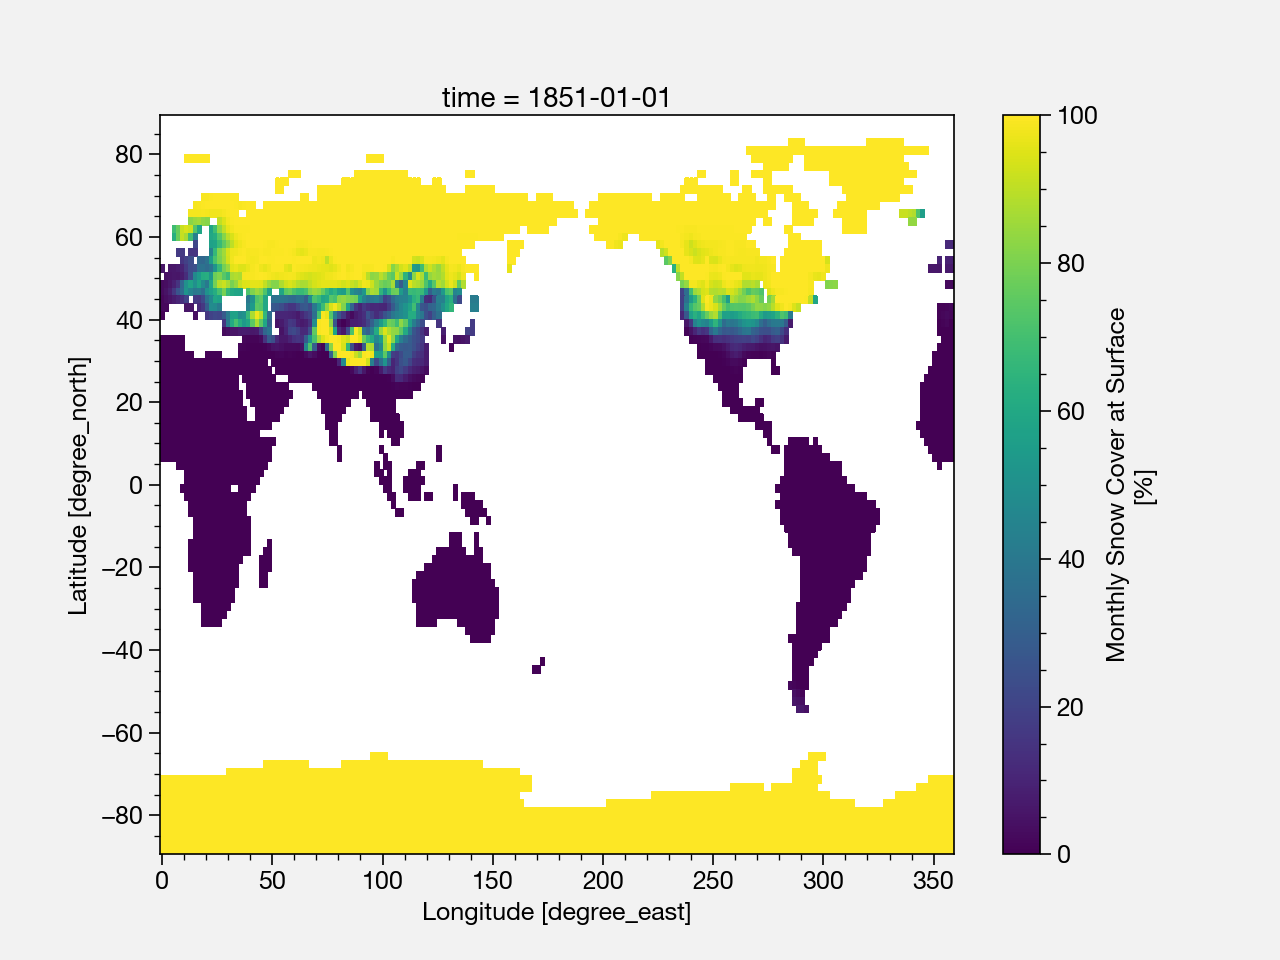

In [36]:
snowc_mon_noaaV2c[0].plot()

In [37]:
# Compute the yearly mean
snowc_noaaV2c_year_mean = u.year_mean(snowc_mon_noaaV2c)
snowc_noaaV2c_year_mean

<xarray.DataArray (year: 164, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 10

In [121]:
regridder_noaa = xe.Regridder(snowc_noaaV2c_year_mean, snc_year_mean, 'bilinear', periodic=True)
regridder_noaa

Overwrite existing file: bilinear_94x192_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_94x192_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (94, 192) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [39]:
snowc_noaaV2c_year_mean_regrid = regridder_noaa(snowc_noaaV2c_year_mean)
snowc_noaaV2c_year_mean_regrid

<xarray.DataArray (year: 164, lat: 143, lon: 144)>
array([[[100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  

In [109]:
with xr.set_options(keep_attrs=True):
    diff = snc_year_mean - snowc_noaaV2c_year_mean_regrid
    
diff

<xarray.DataArray (year: 164, lat: 143, lon: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, na

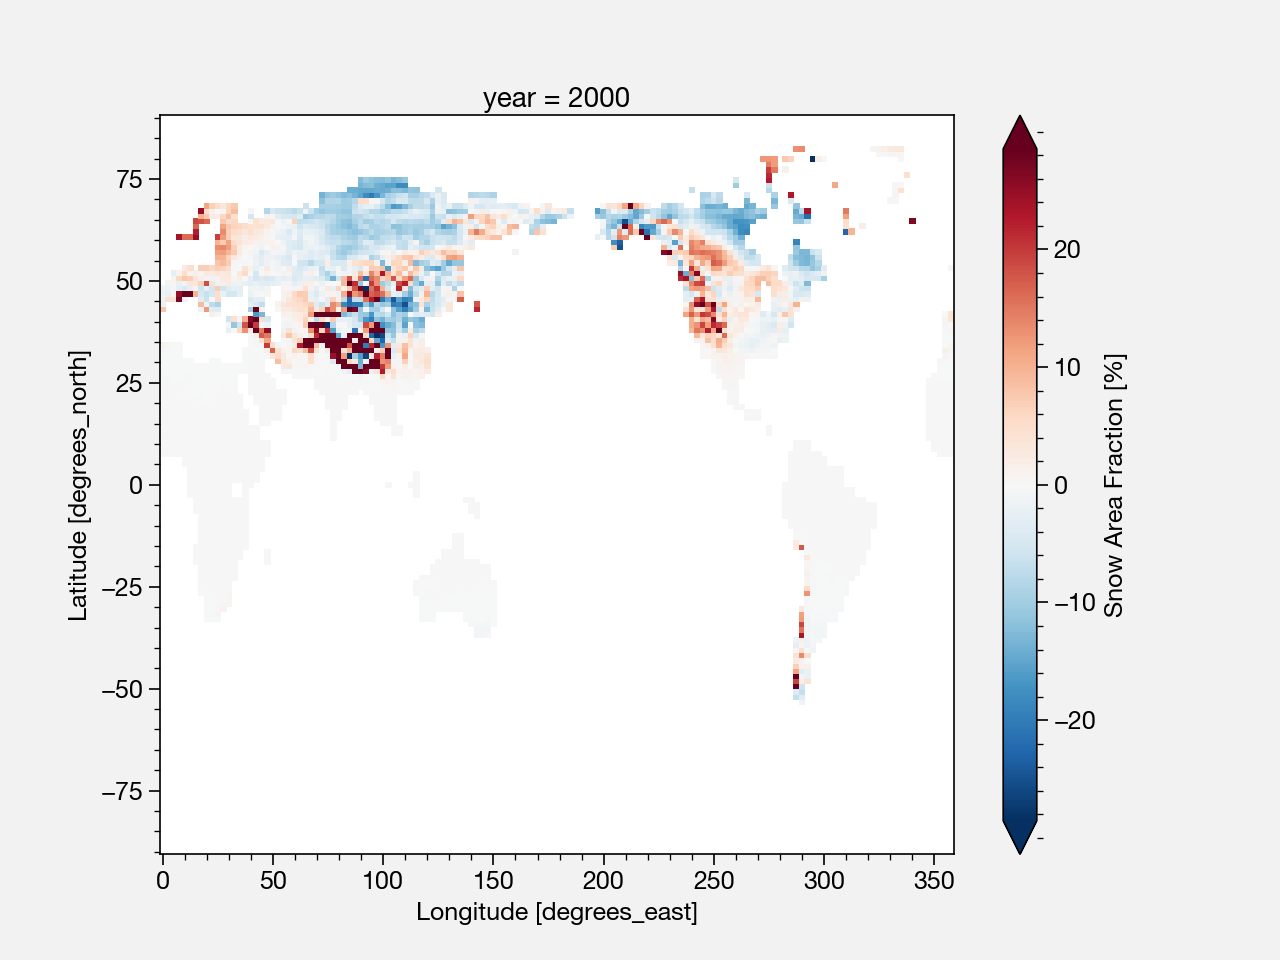

In [52]:
diff.sel(year=2000).plot(robust=True)

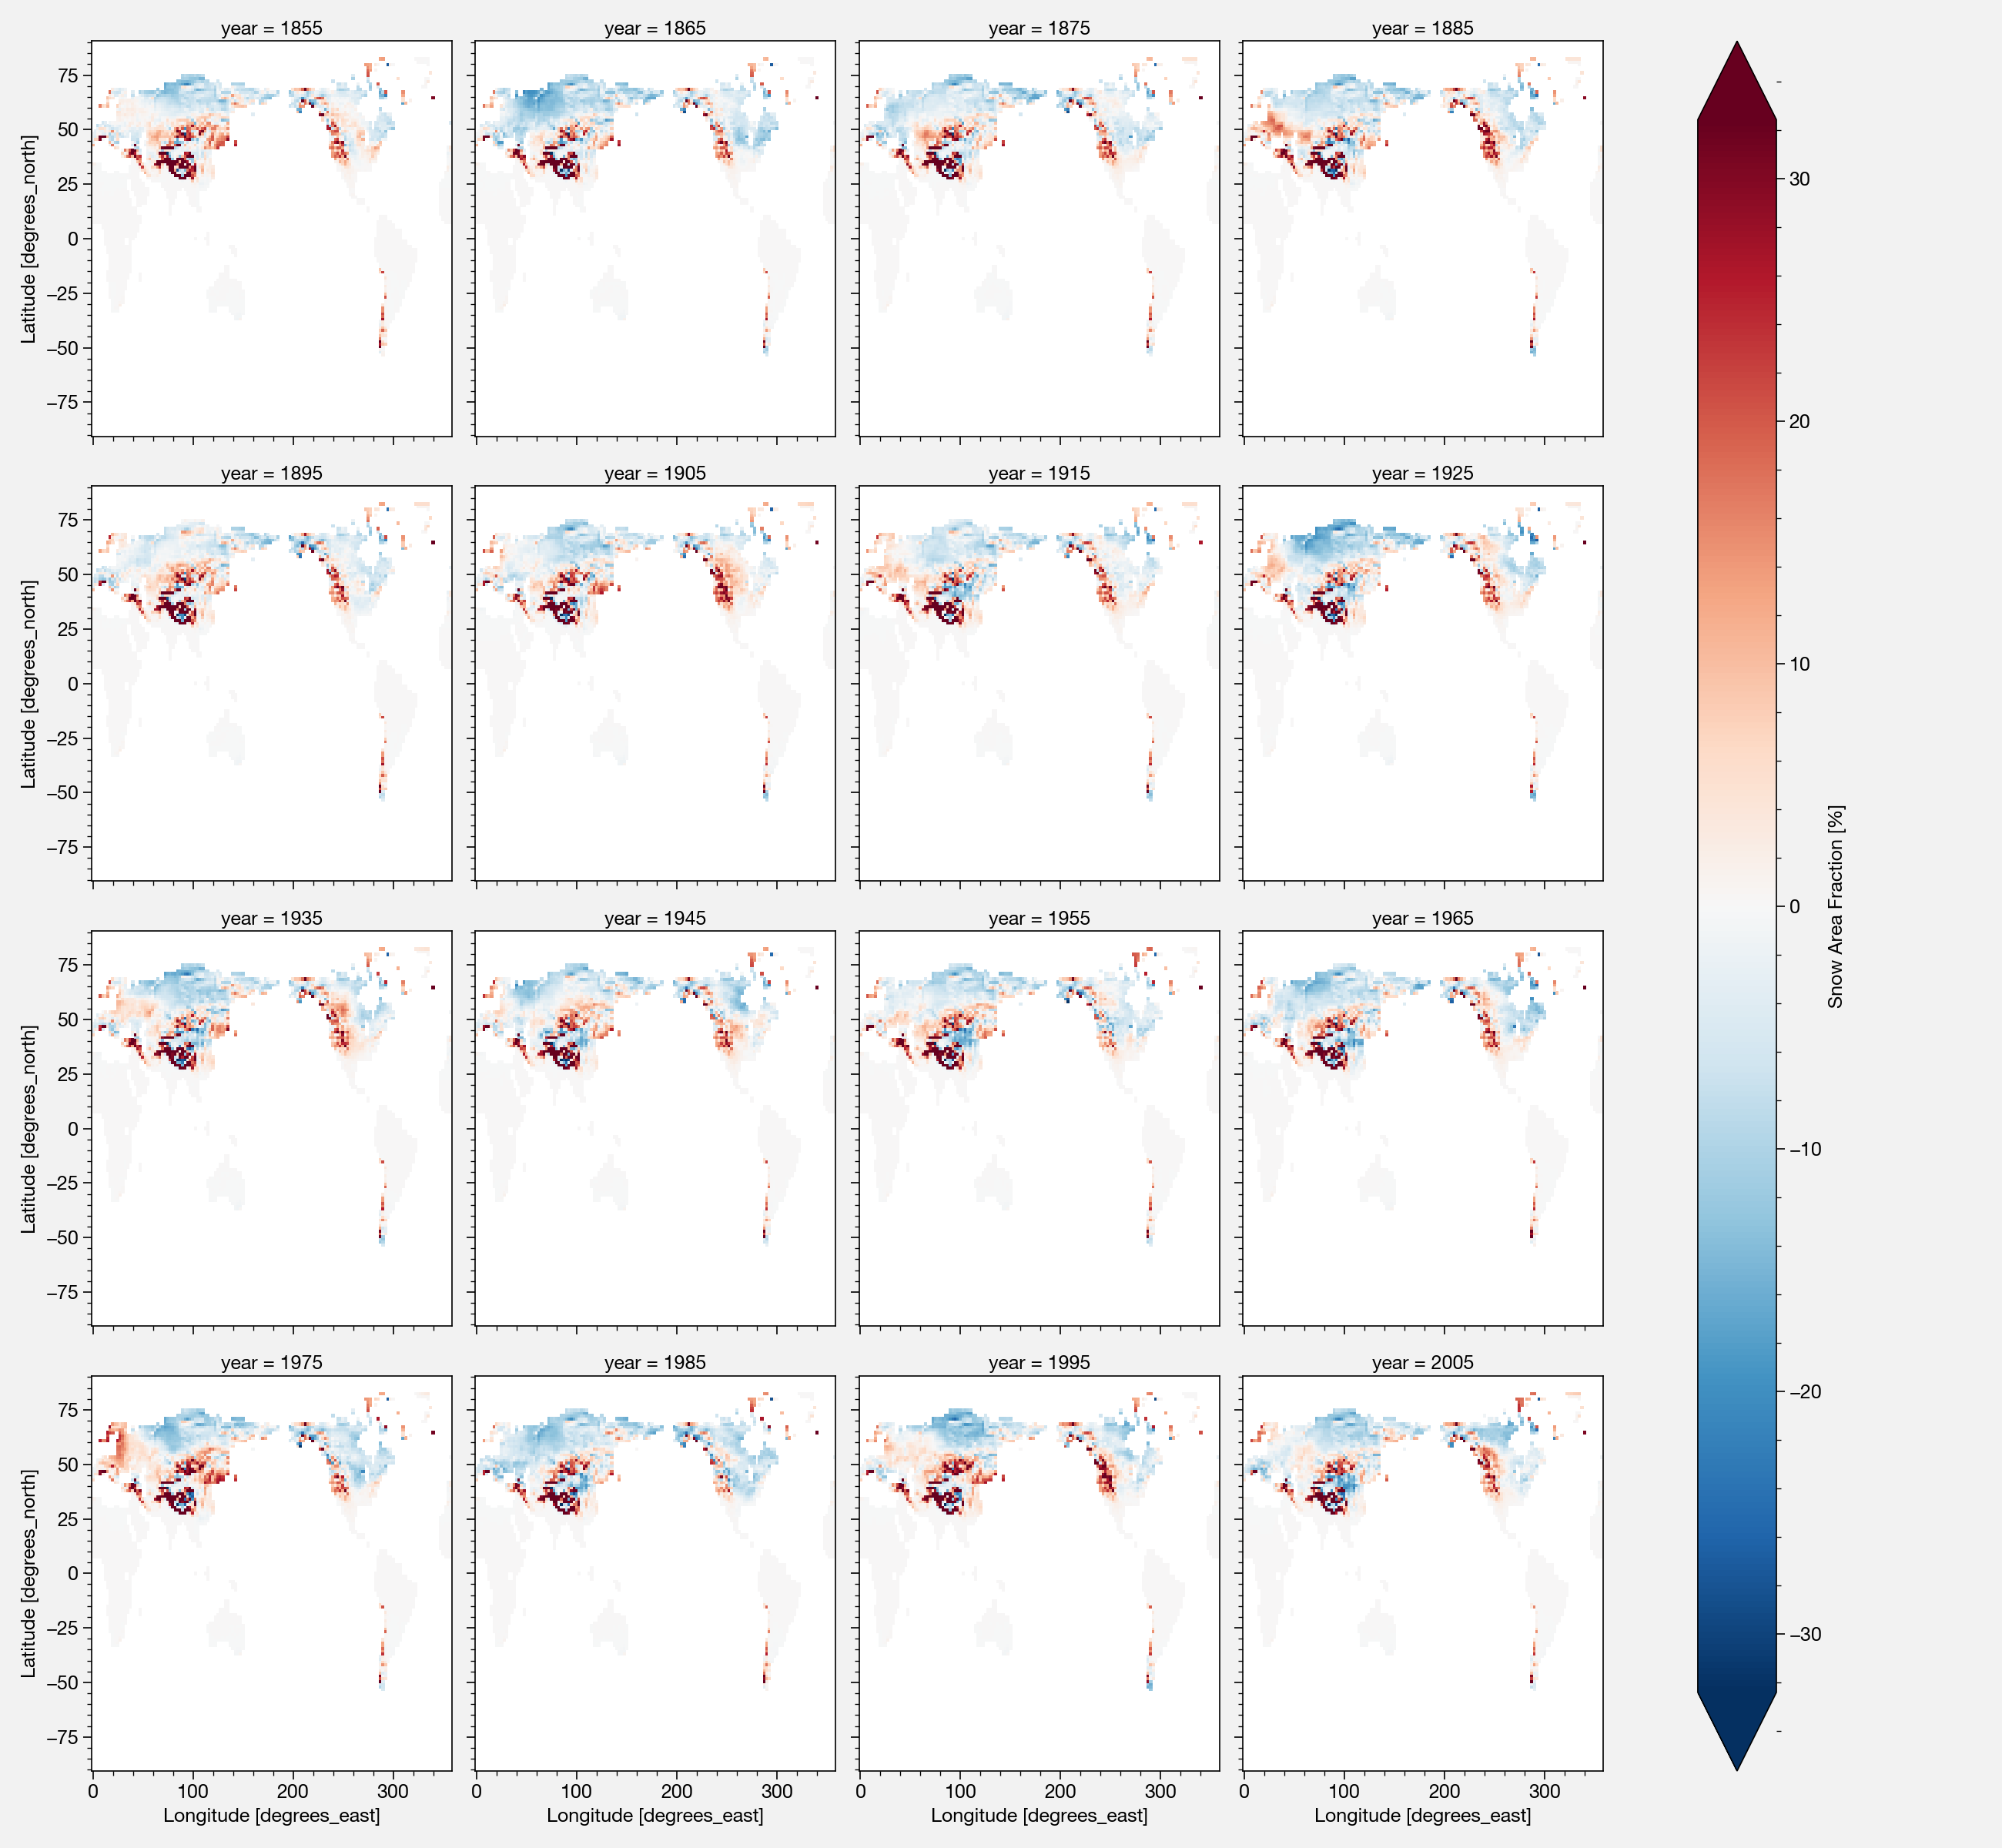

In [110]:
diff[4:-1:10].plot(col='year', col_wrap=4, robust=True)

# The bias is always present! 
Even before the decreasing of snow area fraction.

# Other reanalysis

In [84]:
snowc_mon_ncar = xr.open_dataset('/home/msantola/TP_CLiMAF/SharedObsSnow/snc_ncarcfsr_1979-2016_0.5x0.5.nc').snowc
snowc_mon_ncar = snowc_mon_ncar.where(snowc_mon_ncar<=100)
snowc_mon_ncar

<xarray.DataArray 'snowc' (time: 456, lat: 361, lon: 720)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ...,

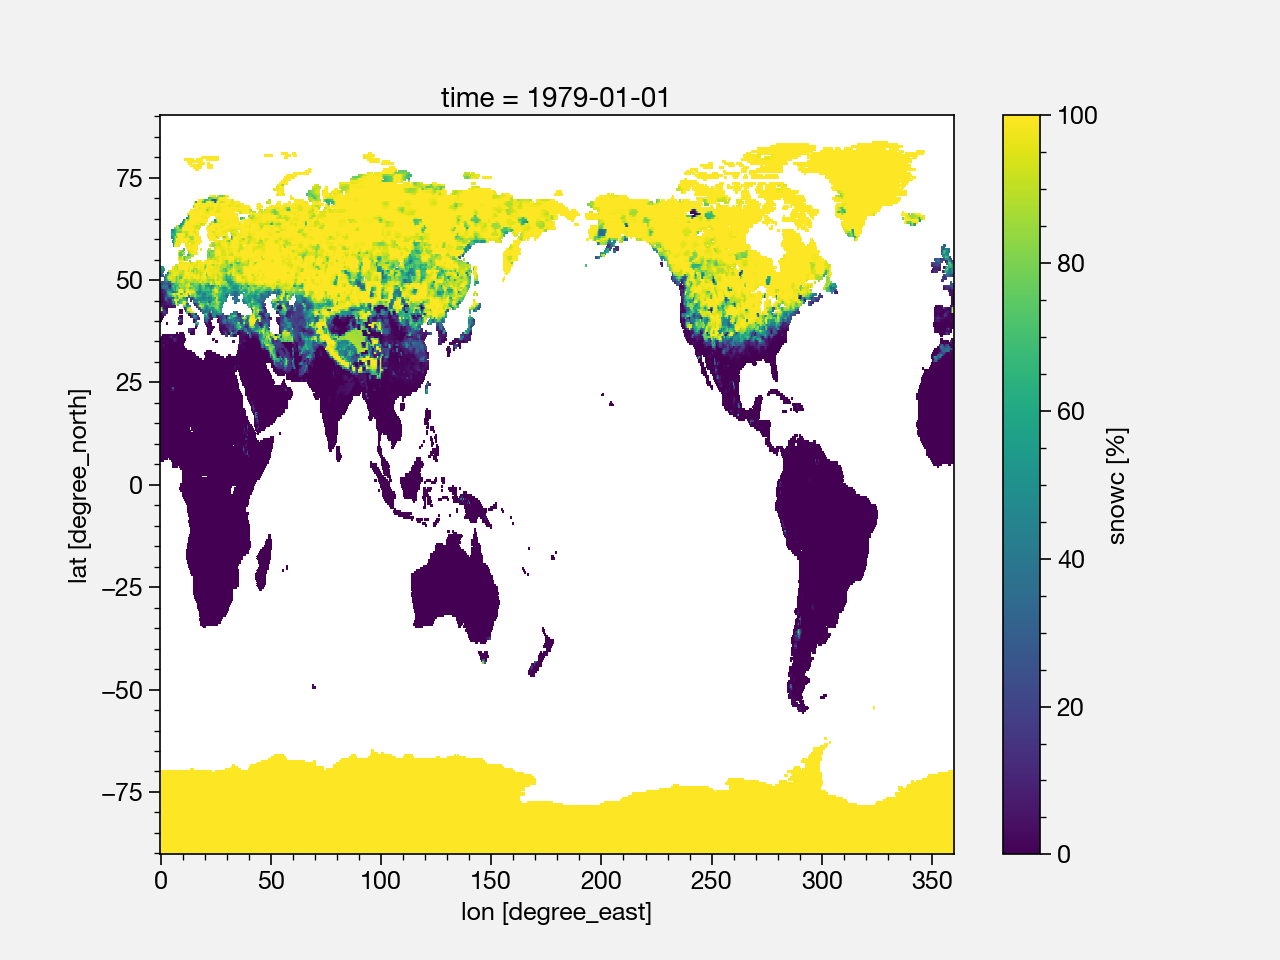

In [85]:
snowc_mon_ncar[0].plot()

In [86]:
# Compute the yearly mean
snowc_ncar_year_mean = u.year_mean(snowc_mon_ncar)
snowc_ncar_year_mean

<xarray.DataArray (year: 38, lat: 361, lon: 720)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 10

In [120]:
regridder_ncar = xe.Regridder(snowc_ncar_year_mean, snc_year_mean, 'bilinear', periodic=True)
regridder_ncar

Overwrite existing file: bilinear_361x720_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x720_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 720) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [88]:
snowc_ncar_year_mean_regrid = regridder_ncar(snowc_ncar_year_mean)
snowc_ncar_year_mean_regrid

<xarray.DataArray (year: 38, lat: 143, lon: 144)>
array([[[100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  n

In [104]:
with xr.set_options(keep_attrs=True):
    diff = snc_year_mean - snowc_ncar_year_mean_regrid
    
diff

<xarray.DataArray (year: 36, lat: 143, lon: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan

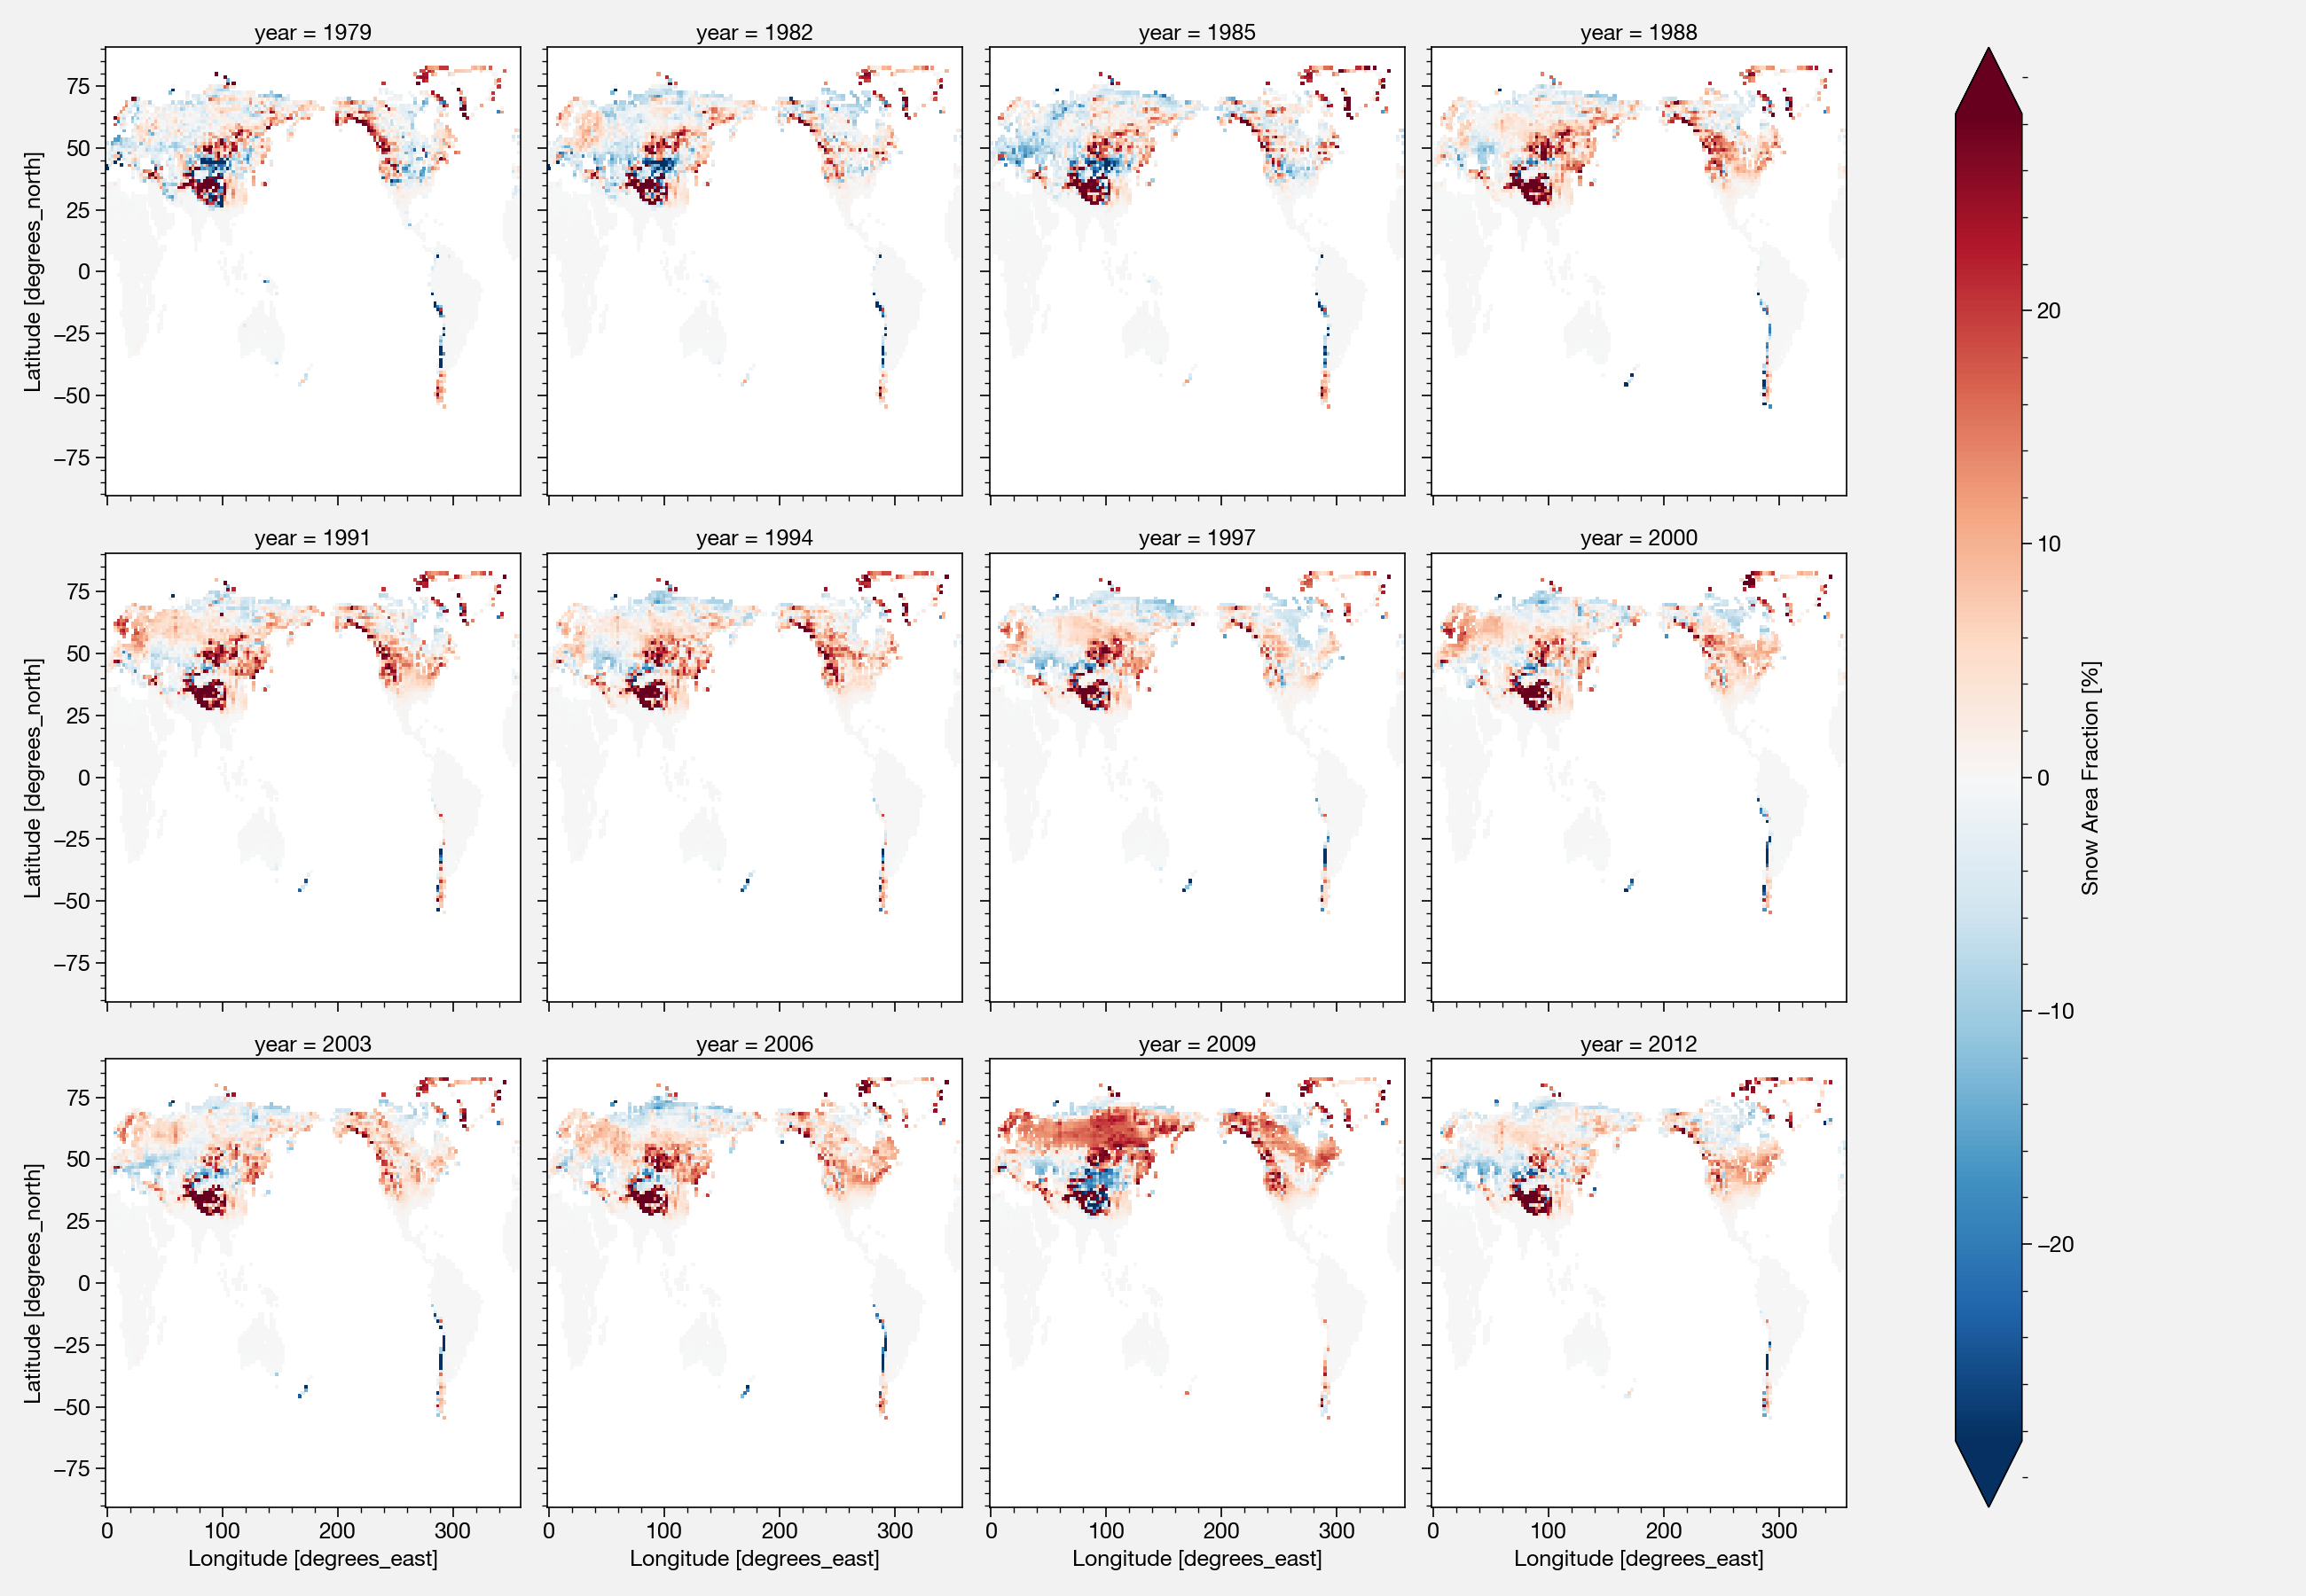

In [108]:
diff[0:-1:3].plot(col='year', col_wrap=4, robust=True)

# Similar result

# Is this bias present for all members?
Let's take a subperiod 1979 to 2014 and let's compare the annual climatology to both reanalyses

In [112]:
snc = u.get_data_IPSL_CM6A_LR_historical('snc', time=slice('1979','2014'))
snc

<xarray.DataArray 'snc' (realization: 32, time: 432, lat: 143, lon: 144)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, n

In [114]:
snc_clim = u.clim(snc, calendar='gregorian')
snc_clim

<xarray.DataArray (realization: 32, lat: 143, lon: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., n

In [115]:
snowc_mon_noaaV2c = xr.open_dataset('/home/msantola/TP_CLiMAF/ReferenceSNOW/SNC/SNCRefData/snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc').snowc.sel(time=slice('1979','2014'))
snowc_mon_noaaV2c

<xarray.DataArray 'snowc' (time: 432, lat: 94, lon: 192)>
[7796736 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


In [116]:
snowc_mon_noaaV2c_clim = u.clim(snowc_mon_noaaV2c, calendar='gregorian')
snowc_mon_noaaV2c_clim

<xarray.DataArray (lat: 94, lon: 192)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name

In [118]:
snowc_mon_ncar = xr.open_dataset('/home/msantola/TP_CLiMAF/SharedObsSnow/snc_ncarcfsr_1979-2016_0.5x0.5.nc').snowc.sel(time=slice('1979','2014'))
snowc_mon_ncar = snowc_mon_ncar.where(snowc_mon_ncar<=100)
snowc_mon_ncar

<xarray.DataArray 'snowc' (time: 432, lat: 361, lon: 720)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ...,

In [119]:
snowc_mon_ncar_clim = u.clim(snowc_mon_ncar, calendar='gregorian')
snowc_mon_ncar_clim

<xarray.DataArray (lat: 361, lon: 720)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])
Coordinates:
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
  * lat      (lat) float64 90.0 89.5 89.0 88.5 88.0 ... -88.5 -89.0 -89.5 -90.0
Attributes:
    units:    %

In [123]:
snowc_mon_noaaV2c_clim_regrid = regridder_noaa(snowc_mon_noaaV2c_clim)
snowc_mon_ncar_clim_regrid = regridder_ncar(snowc_mon_ncar_clim)

In [125]:
with xr.set_options(keep_attrs=True):
    diff_noaa = snc_clim - snowc_mon_noaaV2c_clim_regrid
    diff_ncar = snc_clim - snowc_mon_ncar_clim_regrid

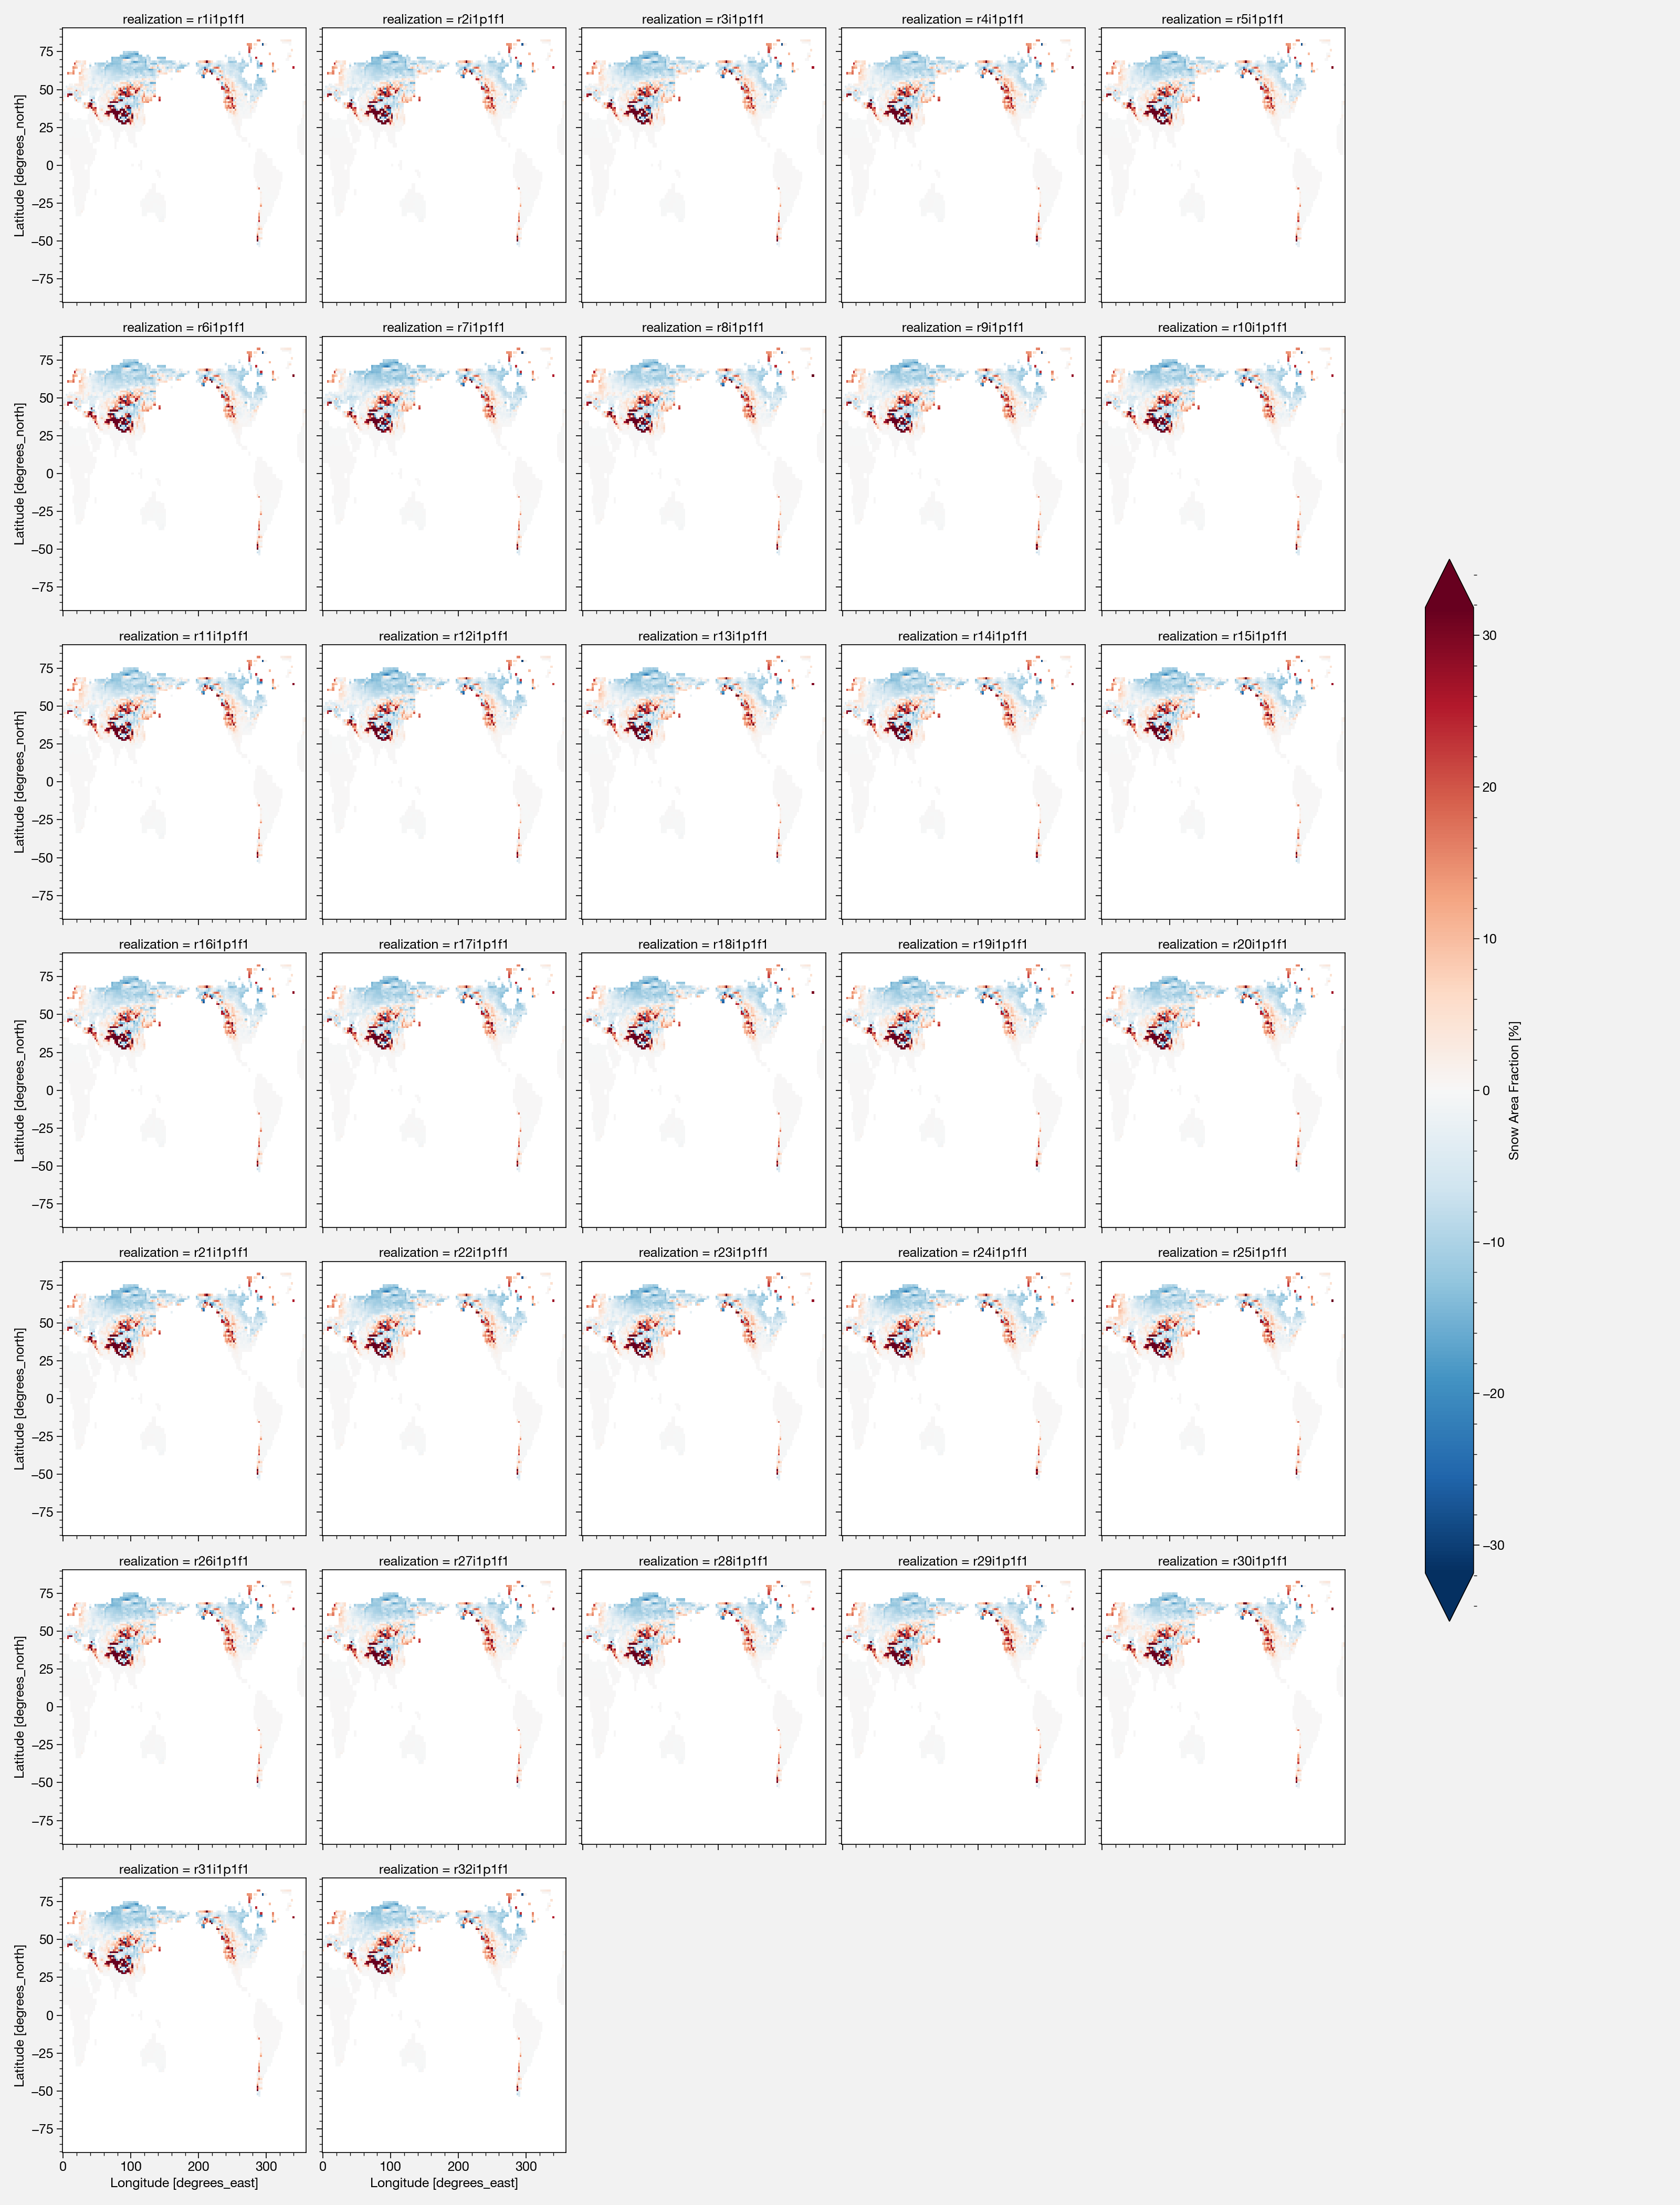

In [136]:
diff_noaa.plot(col='realization', col_wrap=5, robust=True,
              cbar_kwargs={'shrink': 0.5})

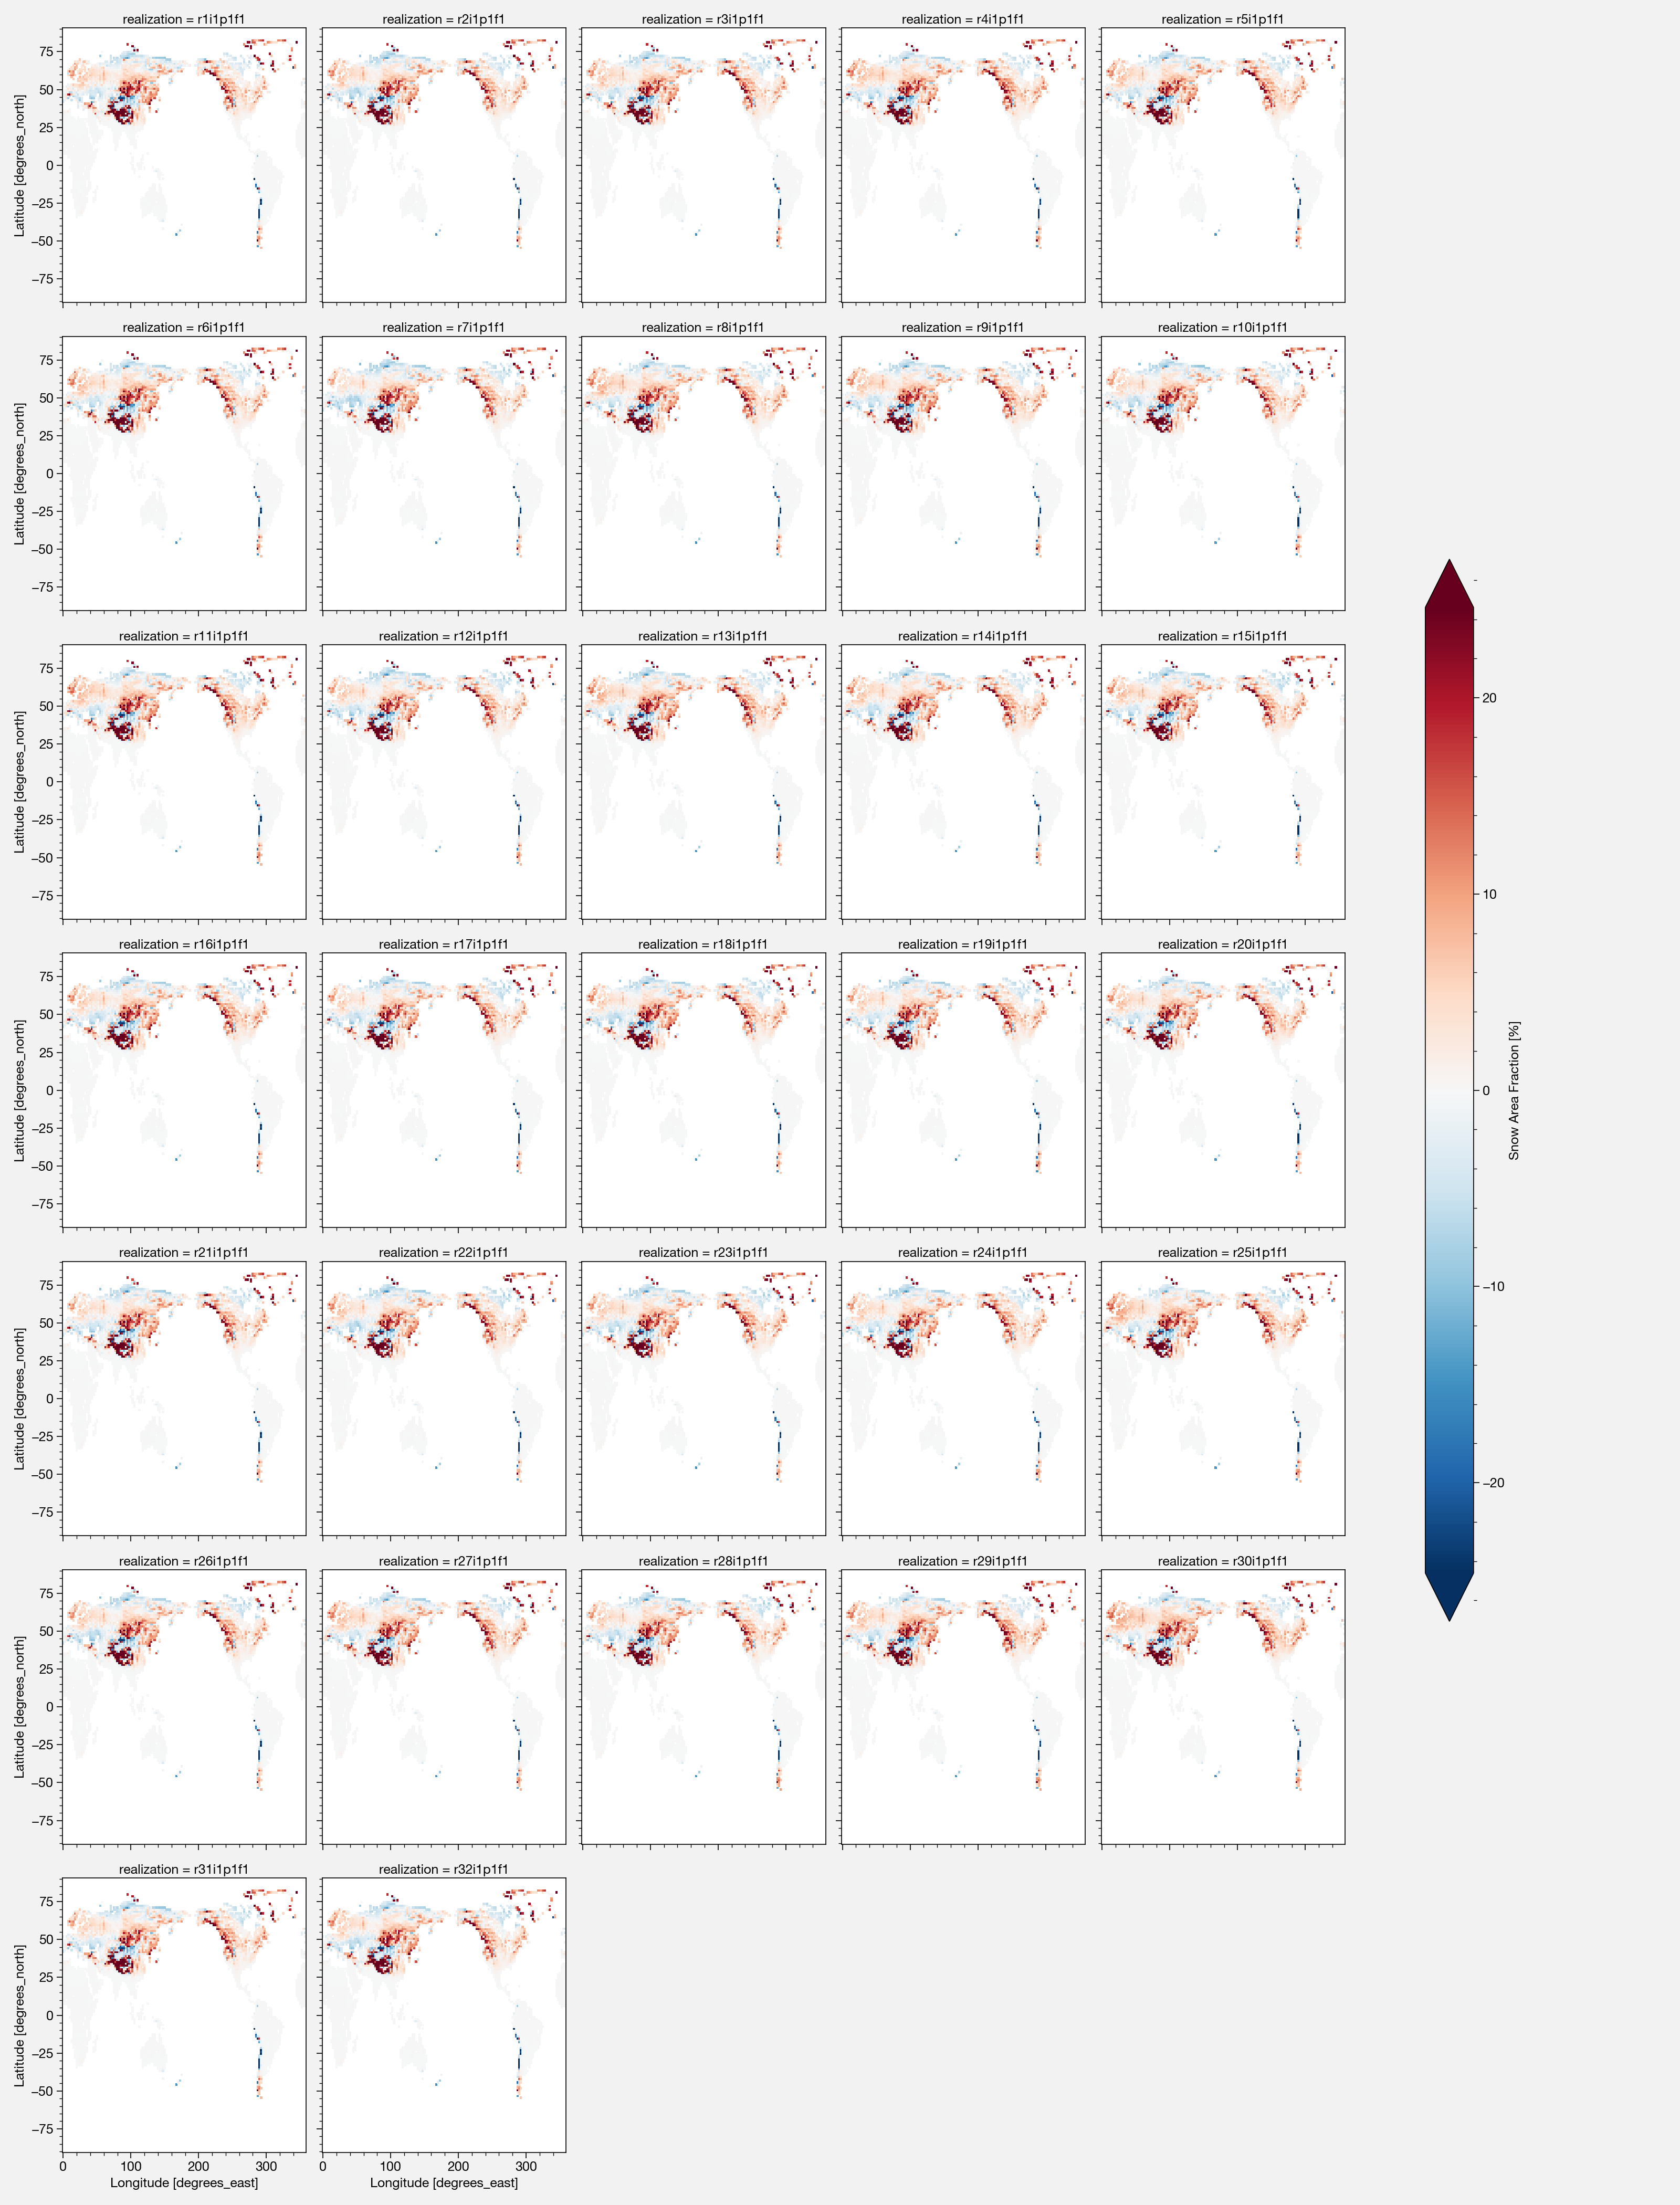

In [137]:
diff_ncar.plot(col='realization', col_wrap=5, robust=True,
              cbar_kwargs={'shrink': 0.5})

# The bias is present for all members!